# Learning Outcomes
- Quantify the image segmentation performances: Intersection over union (IOU).
- Image gradients -> edge detection (image segmentation method)
- Contour (curves joining the boundaries of object (homogeneous region))
- Contour properties and features (area, perimeter, center of mass, bounding box)
- Blob detection

## Setup

In [3]:
!pip install requests

                                              0.0/62.6 kB ? eta -:--:--
     ---------------------------------------- 62.6/62.6 kB 1.1 MB/s eta 0:00:00
                                              0.0/96.6 kB ? eta -:--:--
     -------------------------                61.4/96.6 kB 1.1 MB/s eta 0:00:01
     ---------------------------------------- 96.6/96.6 kB 1.8 MB/s eta 0:00:00
                                              0.0/123.9 kB ? eta -:--:--
     ----------------------------------     112.6/123.9 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 123.9/123.9 kB 2.4 MB/s eta 0:00:00
                                              0.0/158.3 kB ? eta -:--:--
     ----------                              41.0/158.3 kB 1.9 MB/s eta 0:00:01
     ----------                              41.0/158.3 kB 1.9 MB/s eta 0:00:01
     ----------                              41.0/158.3 kB 1.9 MB/s eta 0:00:01
     ------------------------------------ 158.3/158.3 kB 949.3 kB/s et


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [4]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

In [43]:
print(cv.__version__)

4.7.0


## IOU

- Formula:
- IOU = |AnB|/|AuB|
-     = |AnB|/|A+B-AnB|

In [5]:
def computeIOU(boxA, boxB):
    """Args:
    It should be (x1, y1, x2,y2)"""
    
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1) 
    # +1 is to cover every region using 0.5 at each coordinate
    
    # area of A and area of B
    areaA = (boxA[2]- boxA[0] + 1)*(boxA[3]- boxA[1] + 1)
    areaB = (boxB[2]- boxB[0] + 1)*(boxB[3]- boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [6]:
img = cv.imread("images/lena.jfif")

In [15]:
boxes = cv.selectROIs("boxes", img, showCrosshair = False)

cv.waitKey(0)
cv.destroyAllWindows()

#draw, space, draw, space, esc, esc

In [8]:
boxes

array([[ 94, 100,  63,  61],
       [170,  41,  46,  59]])

In [9]:
def convert_xywh_to_xyxy(box):
    return [box[0], box[1], box[0]+box[2], box[1]+box[3]]

In [16]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1]), (gt[2], gt[3]), (0, 0, 255), 1)
cv.rectangle(img_copy, (pred[0], pred[1]), (pred[2], pred[3]), (255, 0, 0), 1)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):.3f}", (10, 25),
          cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

show_img("IOU", img_copy)

# in assignment: set threshold = 0.55

## Image gradients / edge detection
One of the most operators: Sobe. At the backend, convolution with specific kernel:

$$\begin{bmatrix} -1 & 0 & 1 \\ - 2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

- later need to transform this kernel

### caveat (bit depth)

In [17]:
img = cv.imread("images/wood_planck.jfif", 0)

th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

show_img("binary", th)

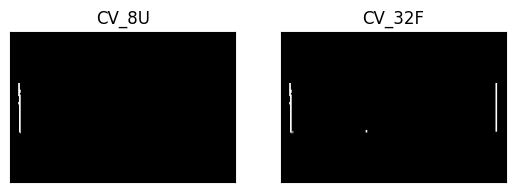

In [19]:
# wrong way   # the negative value become 0
sobelx_8u = cv.Sobel(th, cv.CV_8U, 1, 0, ksize = -1) 
# exchange the 0 and 1 (vertical -> horizontal edge map)

# correct way   # still consider the negative value but after that abs it
sobelx_32f = cv.Sobel(th, cv.CV_32F, 1, 0, ksize = -1) 
# exchange the 0 and 1 (vertical -> horizontal edge map)
sobelx = cv.convertScaleAbs(sobelx_32f)

# ksize = -1 : Scharr operator # larger gradient magnitude

plt.subplot(121), plt_img(sobelx_8u, "CV_8U")
plt.subplot(122), plt_img(sobelx, "CV_32F")
plt.show()

### construct gradient map

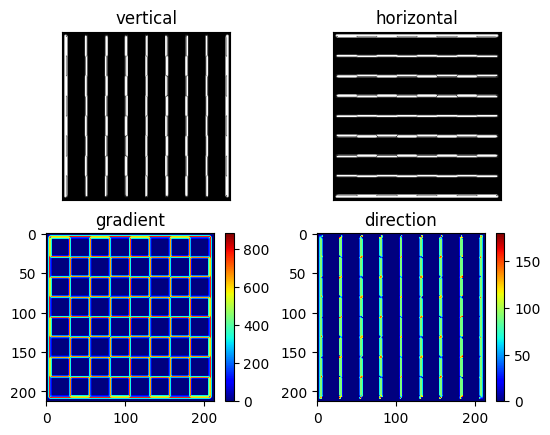

In [20]:
img = cv.imread("images/chessboard.png", 0)

# apply sobel x and sobel y
sobelx = cv.Sobel(img, cv.CV_32F, 1, 0)
sobelx_8u = cv.convertScaleAbs(sobelx)
sobely = cv.Sobel(img, cv.CV_32F, 0, 1)
sobely_8u = cv.convertScaleAbs(sobely)

# gradient
gradient = cv.magnitude(sobelx, sobely)
# direction
direction = np.arctan2(sobelx, sobely) * 180 / np.pi % 180

plt.subplot(221), plt_img(sobelx_8u, "vertical")
plt.subplot(222), plt_img(sobely_8u, "horizontal")
plt.subplot(223), plt.imshow(gradient, cmap="jet"), plt.title("gradient"), plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap="jet"), plt.title("direction"), plt.colorbar()

plt.show()

## canny edge detector
- enchance accuracy by reducing false positives
- flexible

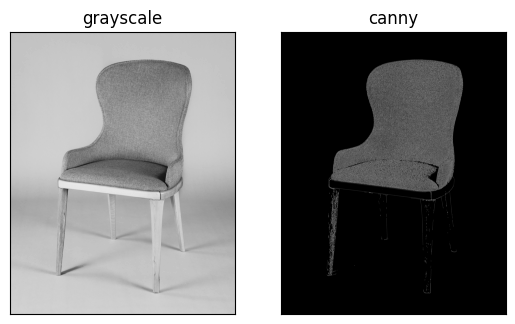

In [21]:
img = cv.imread("images/chair.jpg", 0)
edge =cv.Canny(img, 100, 300) # 50->100, 2->5 for ratio, in this case, 3

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

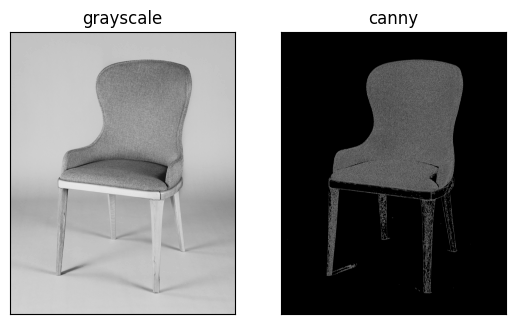

In [22]:
img = cv.imread("images/chair.jpg", 0)
edge =cv.Canny(img, 30, 150) # 50->100, 2->5 for ratio, in this case, 5

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

In [25]:
# simple exercise: adjust one parameter: threshold 1
img = cv.imread("images/bridge.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ratio = 2.5
ksize = 3
wn = "Canny"
trackbarName = "Threshold1"

def cannyThreshold(val):
    """val is Threshold1"""
    edge = cv.Canny(gray, val, val * ratio, apertureSize=ksize)
    # create mask
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8)) # change mask to 3D
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbarName, wn, 10, 100, cannyThreshold)

cv.waitKey(0)
cv.destroyAllWindows()

In [50]:
def auto_canny(img, method, sigma=0.33):
    """Args:
    img: grayscale image
    method: median, otsu, triangle
    sigma: 0.33 (default)"""
    
    if method == "median":
        Th = np.median(img)
        
    elif method == "triangle":
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
        
    elif method == "otsu":
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    Thresh1 = (1-sigma) * Th
    Thresh2 = (1+sigma) * Th
    
    return cv.Canny(img, Thresh1, Thresh2)

### Contour Detection
1. Read an image
2. Threshold / Edge detection
3. The output from step 2 can be parse into `cv.findContour()`
4. (optional) draw contour. `cv.drawContour()`

In [27]:
rect = np.zeros((256,256), dtype=np.uint8)

cv.rectangle(rect, (25, 25), (231, 231), 255, -1)

show_img("rectangle", rect)

In [28]:
contours, _ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

print(contours)

(array([[[ 25,  25]],

       [[ 25, 231]],

       [[231, 231]],

       [[231,  25]]], dtype=int32),)


In [29]:
type(contours)

tuple

In [30]:
contours[0].shape

(4, 1, 2)

In [32]:
img_bgr = cv.cvtColor(rect, cv.COLOR_GRAY2BGR)

cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 2) # -1 means plot every contour

show_img("contour", img_bgr)

In [33]:
img = cv.imread("images/monitor.jfif", 0)

th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

#contour
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 2)

show_img("contour", img_bgr)

In [34]:
len(contours)

12

In [35]:
contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 2)

show_img("contour", img_bgr)

In [38]:
# simple way to sift thru contours
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# select the contour that has the highest number of points
length = [len(c) for c in contours]
cnt = contours[np.argmax(length)]

img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_bgr, [cnt], -1, (0, 255, 0), 2)

show_img("contour", img_bgr)

# result just like cv.RETR_EXTERNAL

## Contour features
- area
- perimeter
- centroid
- bounding box

In [40]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [41]:
# centroid
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])
print(f"The centroid of monitor contour: {(cx, cy)}.")

The centroid of monitor contour: (105, 103).


In [42]:
# area and perimeter
### area = M['m00']
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True)

print(f"Area of monitor contour: {area}")
print(f"Perimeter of monitor contour: {peri:.3f}")

Area of monitor contour: 37113.5
Perimeter of monitor contour: 1056.777


In [51]:
# apply edge detection and contour properties to segment

img = cv.imread("images/remote-controller.webp")

# resize -> grayscale -> bilateral filter -> edge (Canny) -> find contour -> area -> DP approximation

factor = 300 / img.shape[1]
img = cv.resize(img, None, fx=factor, fy=factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = auto_canny(blur, method="triangle")

show_img("edge", edge)

In [53]:
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# sort the contour with respect to contour area in descending order
contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)

    if len(approx) == 4:
        screen = c
        break
        
img_copy = img.copy()
cv.drawContours(img_copy, [screen], -1, (0, 255, 2), 2)
show_img("contour", img_copy)

## Additional Contour Properties
circularity = (4 x PI x Area) / (perimeter)^2

## Demo on red color segmentation

In [60]:
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (179, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam detected")

fixed_width = min_area = 500
factor = fixed_width / cap.get(3) # frame width
kernel = np.ones((3,3), dtype=np.uint8)

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("No frame received")
        break
        
    # resize -> blurring -> change to HSV -> inRange -> mask integration -> morphological operation ->
    # find contour -> bounding box
    
    resized = cv.resize(frame, None, fx=factor, fy=factor)
    blur = cv.GaussianBlur(resized, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    mask = cv.add(mask1, mask2)
    
    #Opening to removes noises
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=2)#iterations dun more than 5
    
    # contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    bbs = []
    centroids = []
    
    for c in contours:
        area = cv.contourArea(c)
        if area > min_area:
            bb = cv.boundingRect(c)
            bbs.append(bb)
            M = cv.moments(c)
            cx, cy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
            
    for bb, centroid in zip(bbs, centroids):
        x, y, w, h = bb
        cv.rectangle(resized, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv.circle(resized, centroid, 2, (255, 0, 0), -1)
        
    cv.imshow("red object", resized)
    k = cv.waitKey(1) & 0xFF
    if k==27:
        break

cv.destroyAllWindows()
cap.release()

## exercise 1

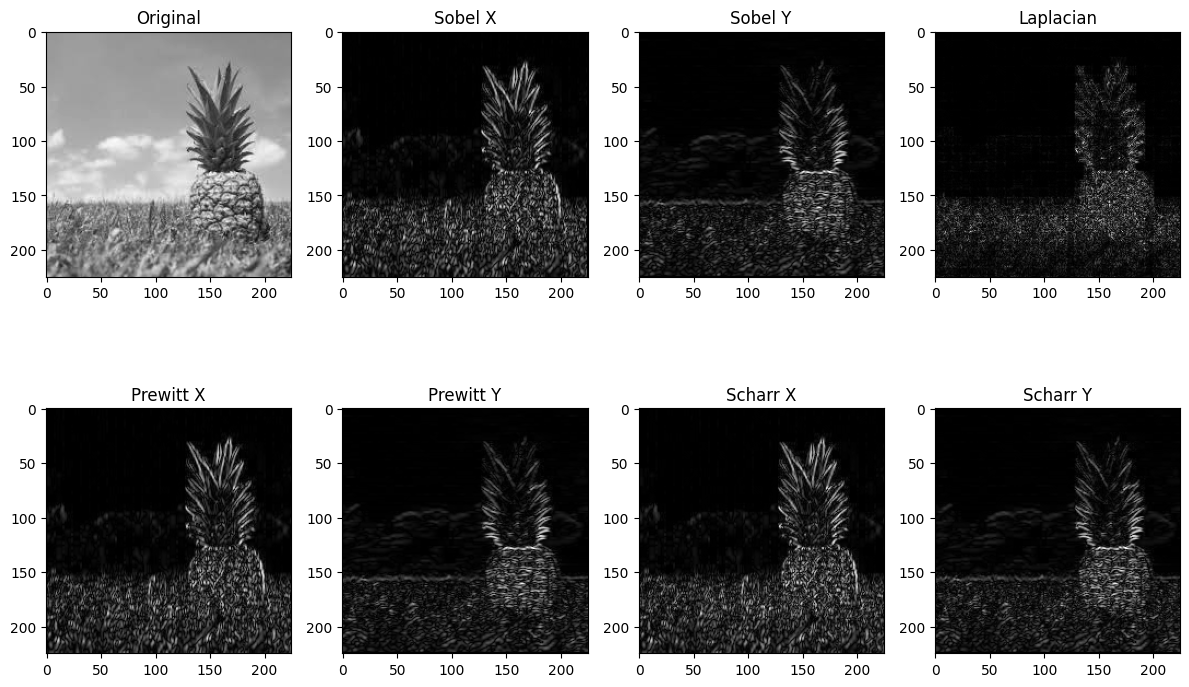

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r'C:\Users\User\Documents\Y3S1\MINI PROJECT\WEEK 8\pineapple.jfif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply different edge detectors
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
laplacian = cv2.Laplacian(image, cv2.CV_64F)
prewitt_x = cv2.filter2D(image, cv2.CV_64F, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
prewitt_y = cv2.filter2D(image, cv2.CV_64F, np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))
scharr_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)
canny = cv2.Canny(image, 100, 200)

# Display the results
plt.figure(figsize=(12, 8))
plt.subplot(2, 4, 1), plt.imshow(image, cmap='gray'), plt.title('Original')
plt.subplot(2, 4, 2), plt.imshow(np.abs(sobel_x), cmap='gray'), plt.title('Sobel X')
plt.subplot(2, 4, 3), plt.imshow(np.abs(sobel_y), cmap='gray'), plt.title('Sobel Y')
plt.subplot(2, 4, 4), plt.imshow(np.abs(laplacian), cmap='gray'), plt.title('Laplacian')
plt.subplot(2, 4, 5), plt.imshow(np.abs(prewitt_x), cmap='gray'), plt.title('Prewitt X')
plt.subplot(2, 4, 6), plt.imshow(np.abs(prewitt_y), cmap='gray'), plt.title('Prewitt Y')
plt.subplot(2, 4, 7), plt.imshow(np.abs(scharr_x), cmap='gray'), plt.title('Scharr X')
plt.subplot(2, 4, 8), plt.imshow(np.abs(scharr_y), cmap='gray'), plt.title('Scharr Y')
plt.tight_layout()
plt.show()


## exercise 2

In [3]:
import cv2
import numpy as np

# Load the image
image_path = r'C:\Users\User\Documents\Y3S1\MINI PROJECT\WEEK 8\electronic.jfif'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Find contours in the edge map
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate over the detected contours
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 100:  # Adjust the area threshold as needed
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with bounding boxes
cv2.imshow("Object Detection", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


## exercise 3

In [9]:
import cv2
import numpy as np

# Load the image
image_path = r'C:\Users\User\Documents\Y3S1\MINI PROJECT\WEEK 8\clock.jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Hough Circle Transform to detect circles
circles = cv2.HoughCircles(
    blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=30, param1=50, param2=30, minRadius=40, maxRadius=50
)

# If circles are detected, isolate the clock face
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]

        # Create a circular mask
        mask = np.zeros_like(gray)
        cv2.circle(mask, center, radius, 255, -1)

        # Apply the mask to the grayscale image
        isolated_clock_face = cv2.bitwise_and(gray, gray, mask=mask)

        # Display the isolated clock face
        cv2.imshow("Isolated Clock Face", isolated_clock_face)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
else:
    print("No circles detected.")
